<a href="https://colab.research.google.com/github/shukiBenishty/mars/blob/main/non_linreg_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext tensorboard

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
import io
from datetime import *

# Prepare logs directory for Tensorboard

In [3]:
# Clear out any prior log data.
!rm -rf logs

logdir = "logs/linreg_keras/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# Creates a file writer for the log directory.
file_writer = tf.summary.create_file_writer(logdir)

# Load data

In [4]:
from google.colab import files
import os.path

if(not os.path.isfile("ds.csv") ):
  uploader = files.upload()
  io.StringIO(uploader['ds.csv'].decode('utf-8'))

ds = np.genfromtxt('ds.csv', delimiter=',')

Saving ds.csv to ds.csv


In [5]:
ds_len = ds.shape[0]

shuffled = tf.random.shuffle(ds)
train_len =  int(ds_len * 0.7)
test_len = int(ds_len * 0.3)
validation_len = ds_len - (train_len + test_len)


ds_train, ds_test, ds_validation = tf.split(shuffled, [train_len, test_len, validation_len])

X_train, Y_train = np.hsplit(ds_train, 2)
X_test, Y_test = np.hsplit(ds_test, 2)
X_validation, Y_validation = np.hsplit(ds_validation, 2)


# x_len = 1000

# X = tf.random.uniform(shape=(x_len, 1), minval=-10 , maxval=10)

# _X = tf.random.shuffle(X)
# X_train, X_test, X_validation = tf.split(_X, [int(x_len * 0.7), int(x_len *0.2), int(x_len *0.1)])

# def target(x):
#   noise =  tf.random.normal(shape=(len(x),1) , mean=0.0, stddev=0.2)

#   # return (x**4) + (-0.5 * x) +5 + noise
#   return np.sin(x*2) * x + 5

# Y_train = target(X_train)
# Y_test = target(X_test)
# Y_validation = target(X_validation)

In [6]:
def gen_plot(figure):
    """Create a pyplot plot and save to buffer."""
    buf = io.BytesIO()
    figure.savefig(buf, format='png')
    buf.seek(0)
    return buf


# Create and train the model

In [11]:
#base on cybenko theorem

tensorboardCallback = tf.keras.callbacks.TensorBoard() 
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping( 
    monitor='loss',
    min_delta=1e-5,
    mode="min",
    restore_best_weights=True,
    patience=30, verbose=1
)
# checkpoint_path = 'tmp/checkpoint'
# checkpoint_dir = os.path.dirname(checkpoint_path)
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_path,
#     save_weights_only=True,
#     monitor='loss',
#     mode='max',
#     save_best_only=True)

model = keras.Sequential([
  keras.layers.Dense(128,  activation=keras.activations.sigmoid),
  keras.layers.Dense(1)
])
model.compile(loss=tf.losses.mean_squared_error,
              optimizer=tf.optimizers.Adam(0.01))
# latest = tf.train.latest_checkpoint(checkpoint_dir)
# model.load_weights(latest)

model.fit(X_train, Y_train, epochs=10000, 
          
          batch_size=100,
          verbose=True,
          validation_data=(X_validation, Y_validation),
  callbacks=[
    tensorboardCallback,
    # earlyStoppingCallback,
    # model_checkpoint_callback
])

# model.load_weights(checkpoint_path)

model.summary()

Streaming output truncated to the last 5000 lines.
Epoch 7507/10000
2/2 [==============================] - 0s 90ms/step - loss: 16.4485
Epoch 7508/10000
2/2 [==============================] - 0s 72ms/step - loss: 15.8959
Epoch 7509/10000
2/2 [==============================] - 0s 95ms/step - loss: 16.4935
Epoch 7510/10000
2/2 [==============================] - 0s 75ms/step - loss: 17.0164
Epoch 7511/10000
2/2 [==============================] - 0s 105ms/step - loss: 14.4654
Epoch 7512/10000
2/2 [==============================] - 0s 75ms/step - loss: 15.3052
Epoch 7513/10000
2/2 [==============================] - 0s 88ms/step - loss: 15.5718
Epoch 7514/10000
2/2 [==============================] - 0s 69ms/step - loss: 16.0735
Epoch 7515/10000
2/2 [==============================] - 0s 97ms/step - loss: 15.6568
Epoch 7516/10000
2/2 [==============================] - 0s 102ms/step - loss: 16.2586
Epoch 7517/10000
2/2 [==============================] - 0s 64ms/step - loss: 16.4966
Epoch 7518/1

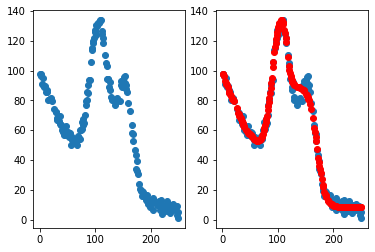

In [12]:
fig, ax = plt.subplots(1, 2)
fig.title = "Results"
ax[0].scatter(X_train, Y_train)

ax[1].scatter(X_train, Y_train)
ax[1].scatter(X_train, model.predict(X_train), color='red')

# Prepare the plot
plot_buf = gen_plot(fig)
# Convert PNG buffer to TF image
image = tf.image.decode_png(plot_buf.getvalue(), channels=4) 
image = tf.expand_dims(image, 0)

#write to log
formatted_vals = [ "var: {}, value: {}".format(v.name, v.numpy()) for v in model.trainable_variables]
with file_writer.as_default():
  tf.summary.image("Results", image, step=0)
  tf.summary.text("Trainable variables names: ", 
                formatted_vals,
                step=0)



In [14]:
model.predict([19])

array([[80.944855]], dtype=float32)

In [ ]:
%tensorboard --logdir logs